<a href="https://colab.research.google.com/github/laloflogar/RB2026/blob/main/Gr%C3%A1ficas_nacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gráfica 1: Producto Interno Bruto

Llamar a la API

In [ ]:
import requests
import json
import pandas as pd
from functools import reduce

# =========================
# CONFIGURACIÓN
# =========================
token = '337db32f-2268-33f9-43e8-c853b84b6ee9'

series_ids = {
    '736182': "PIB Var Trimestral, a.e.",
    '736181': "PIB Trimestral, a.e.",
    '736180': "PIB Var Anual",
    '736183': "PIB Var Anual, a.e."
}

# =========================
# FUNCIÓN DE DESCARGA
# =========================
def obtener_serie(serieID, token, serie_name):
    url = (
        f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/'
        f'jsonxml/INDICATOR/{serieID}/es/00/false/BIE-BISE/2.0/{token}?type=json'
    )
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Error en serie {serieID}")
        return None

    content = json.loads(response.content)
    obs = content['Series'][0]['OBSERVATIONS']

    df = pd.DataFrame(obs)[['TIME_PERIOD', 'OBS_VALUE']]
    df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')
    df.rename(columns={'OBS_VALUE': serie_name}, inplace=True)

    # 🔑 CONVERSIÓN A PERIODO TRIMESTRAL
    # Ejemplo: '2024/01' → Period('2024Q1')
    # The previous code transformed 'YYYY/MM' to 'YYYYQMM', which is not a valid quarterly period format.
    # It should be 'YYYYQ<quarter_number>', e.g., '2024Q1'.
    # Correct approach: convert to datetime, then to Period with quarterly frequency.
    df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], format='%Y/%m')
    df['TIME_PERIOD'] = df['TIME_PERIOD'].dt.to_period('Q')

    return df

# =========================
# DESCARGA DE SERIES
# =========================
lista_dataframes = [
    obtener_serie(id_, token, name)
    for id_, name in series_ids.items()
]

lista_dataframes = [df for df in lista_dataframes if df is not None]

# =========================
# MERGE
# =========================
df_final = reduce(
    lambda l, r: pd.merge(l, r, on='TIME_PERIOD', how='outer'),
    lista_dataframes
)

# Orden cronológico correcto
df_final = df_final.sort_values('TIME_PERIOD')

# TIME_PERIOD como índice trimestral
df_final = df_final.set_index('TIME_PERIOD')

print(df_final.tail())


             PIB Var Trimestral, a.e.  PIB Trimestral, a.e.  PIB Var Anual  \
TIME_PERIOD                                                                  
2025Q1                       0.228787          2.537532e+07       1.039441   
2025Q1                       0.228787          2.537532e+07       0.396661   
2025Q1                       0.228787          2.537532e+07       0.396661   
2025Q1                       0.228787          2.537532e+07       0.396661   
2025Q1                       0.446189          2.537532e+07       1.039441   

             PIB Var Anual, a.e.  
TIME_PERIOD                       
2025Q1                  0.419863  
2025Q1                 -0.194255  
2025Q1                  1.003324  
2025Q1                  0.419863  
2025Q1                  1.003324  


Crear el íncice base 2019-IV=100

In [ ]:
df_rebased = df_final.copy()

# Convierte el índice TIME_PERIOD en objetos datetime si aún no lo es
df_rebased.index = df_rebased.index.to_timestamp()

# Filtrar 2019 para obtener el valor base (media del año)
df_2019 = df_rebased[df_rebased.index.year == 2019]
base_value_desest = df_2019['PIB Trimestral, a.e.'].mean()

# Cambiar la base 2019=100
df_rebased['PIB Trimestral, a.e.'] = (df_rebased['PIB Trimestral, a.e.'] / base_value_desest) *100

# Display the head and tail of the new DataFrame with rebased columns
print("DataFrame con PIB rebasado a 2019=100:")
display(df_rebased.head())
display(df_rebased.tail())

DataFrame con PIB rebasado a 2019=100:


,"PIB Var Trimestral, a.e.","PIB Trimestral, a.e.",PIB Var Anual,"PIB Var Anual, a.e."
TIME_PERIOD,,,,
1980-01-01,2.335956,43.743953,NaN,NaN
1980-01-01,2.335956,42.624485,NaN,NaN
1980-01-01,0.283766,42.624485,NaN,NaN
1980-01-01,2.335956,42.745439,NaN,NaN
1980-01-01,0.283766,43.743953,NaN,NaN


,"PIB Var Trimestral, a.e.","PIB Trimestral, a.e.",PIB Var Anual,"PIB Var Anual, a.e."
TIME_PERIOD,,,,
2025-01-01,0.228787,105.103721,1.039441,0.419863
2025-01-01,0.228787,105.103721,0.396661,-0.194255
2025-01-01,0.228787,105.103721,0.396661,1.003324
2025-01-01,0.228787,105.103721,0.396661,0.419863
2025-01-01,0.446189,105.103721,1.039441,1.003324


In [ ]:
fecha_inicio='2018-01-01'
base_filtrada = df_rebased[df_rebased.index >= fecha_inicio].copy()
display(base_filtrada.tail())

,"PIB Var Trimestral, a.e.","PIB Trimestral, a.e.",PIB Var Anual,"PIB Var Anual, a.e."
TIME_PERIOD,,,,
2024-03-01,0.909260,105.680760,1.400972,1.280210
2024-04-01,-0.578867,105.069009,0.267262,0.368927
2025-01-01,0.228787,105.309393,0.396661,0.419863
2025-02-01,0.446189,105.779272,1.039441,1.003324
2025-03-01,-0.287203,105.475470,-0.119997,-0.194255


In [ ]:
# 1. Asegurar orden y convertir a PeriodIndex trimestral
df = base_filtrada.copy().sort_index()
df.index = df.index.to_period('Q')

# 2. Crear eje X numérico uniforme
x = np.arange(len(df))

# Gráfica 2: variaciones anuales en por ciento

Llamado al API

In [ ]:
import requests
import json
import pandas as pd

#Llamado al API
token='337db32f-2268-33f9-43e8-c853b84b6ee9'
original='735904' # Serie para PIB Original
desest='736183' # Serie para PIB Desestacionalizado
fecha_inicio='2018-01-01'
url1='https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/'+original+'/es/00/false/BIE-BISE/2.0/'+token+'?type=jsonn'
url2='https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/'+desest+'/es/00/false/BIE-BISE/2.0/'+token+'?type=jsonn'


# VARIACIÓN DEL PIB SERIES ORIGINALES
response = requests.get(url1)
if response.status_code == 200:
    content = json.loads(response.content)
    series_original = content['Series'][0]['OBSERVATIONS']

    # Crear DataFrame para la serie original
    df_original = pd.DataFrame(series_original)
    df_original = df_original.rename(columns={'OBS_VALUE': 'var_PIB_original'})
    df_original['var_PIB_original'] = pd.to_numeric(df_original['var_PIB_original'], errors='coerce')
    df_original = df_original[['TIME_PERIOD', 'var_PIB_original']]
else:
    print(f"Error al obtener datos de la serie original: {response.status_code}")
    df_original = pd.DataFrame()

# VARIACIÓN DEL PIB SERIES DESESTACIONALIZADAS
response = requests.get(url2)
if response.status_code == 200:
    content = json.loads(response.content)
    series_desest = content['Series'][0]['OBSERVATIONS']

    # Crear DataFrame para la serie desestacionalizada
    df_desest = pd.DataFrame(series_desest)
    df_desest = df_desest.rename(columns={'OBS_VALUE': 'var_PIB_desest'})
    df_desest['var_PIB_desest'] = pd.to_numeric(df_desest['var_PIB_desest'], errors='coerce')
    df_desest = df_desest[['TIME_PERIOD', 'var_PIB_desest']]
else:
    print(f"Error al obtener datos de la serie desestacionalizada: {response.status_code}")
    df_desest = pd.DataFrame()

# Fusionar los DataFrames si ambos tienen datos
if not df_original.empty and not df_desest.empty:
    base = pd.merge(df_original, df_desest, on='TIME_PERIOD', how='outer')
elif not df_original.empty:
    base = df_original
elif not df_desest.empty:
    base = df_desest
else:
    base = pd.DataFrame() # Crear un DataFrame vacío si no se pudo descargar ningún dato

# Convert TIME_PERIOD to datetime objects
if not base.empty:
    base['TIME_PERIOD'] = pd.to_datetime(base['TIME_PERIOD'], format='%Y/%m')

# Set TIME_PERIOD as index
base = base.set_index('TIME_PERIOD')

# Filtrar el Dataframe desde la fecha de inicio
base_filtrada = base[base.index >= fecha_inicio].copy()

display(base_filtrada.head())
display(base_filtrada.tail())

,var_PIB_original,var_PIB_desest
TIME_PERIOD,,
2018-01-01,1.125548,2.169519
2018-02-01,2.890753,1.743777
2018-03-01,2.750042,2.768490
2018-04-01,1.136534,1.162598
2019-01-01,0.942800,-0.074254


,var_PIB_original,var_PIB_desest
TIME_PERIOD,,
2024-03-01,1.400972,1.280210
2024-04-01,0.267262,0.368927
2025-01-01,0.558752,0.419863
2025-02-01,-0.068081,1.003324
2025-03-01,-0.119997,-0.194255


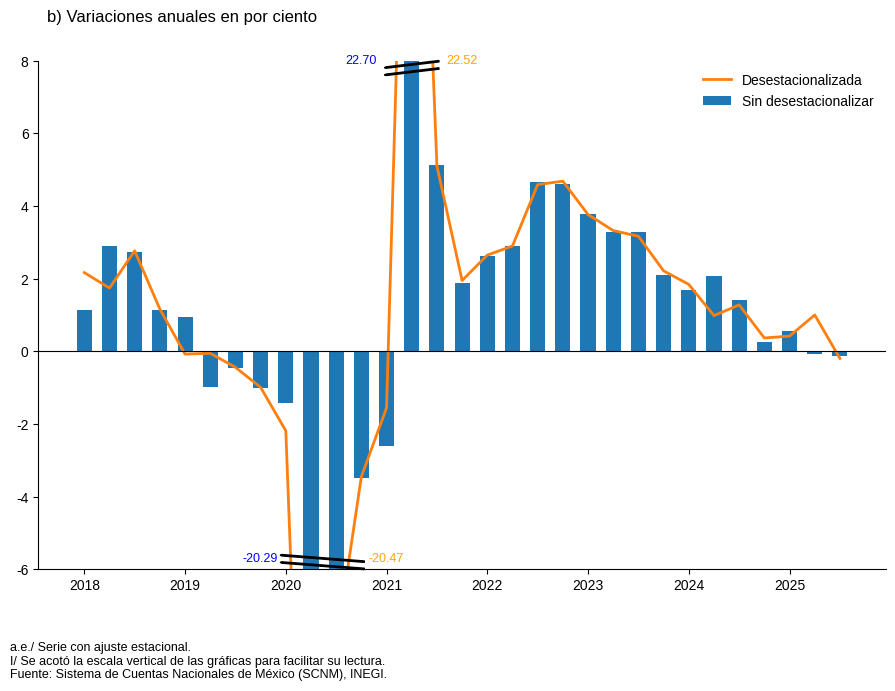

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Tipografía
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'Liberation Sans']
plt.rcParams['axes.unicode_minus'] = False

# 1. Asegurar orden y convertir a PeriodIndex trimestral
df = base_filtrada.copy().sort_index()
df.index = df.index.to_period('Q')

# 2. Crear eje X numérico uniforme
x = np.arange(len(df))

# 3. Figura
fig, ax = plt.subplots(figsize=(9, 7)) # Aumentar el tamaño de la figura

# 4. Barras: sin desestacionalizar
ax.bar(
    x,
    df['var_PIB_original'],
    width=0.6,
    color='#1f77b4',
    label='Sin desestacionalizar'
)

# 5. Línea: desestacionalizada
ax.plot(
    x,
    df['var_PIB_desest'],
    color='#ff7f0e',
    linewidth=2,
    label='Desestacionalizada'
)

# 6. Línea horizontal en cero
ax.axhline(0, color='black', linewidth=0.8)

# 7. Etiquetas del eje X (solo años)
ax.set_xticks(x[::4])
ax.set_xticklabels(df.index.astype(str)[::4].str[:4])

# 8. Límites eje Y
ax.set_ylim(-6, 8)

# 9. Títulos y formato
fig.suptitle('', ha='left', x=0.3, y=0.95, fontsize=16) # Título principal de la figura
ax.set_title('b) Variaciones anuales en por ciento', x=0.01, y=1.05, loc='left', pad=10) # Aumentar el padding del título

ax.legend(frameon=False)

# Estilo limpio
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Lineas de acotación
ax.annotate(
    '',  # Sin texto
    xy=(x[0] + 7.6, -5.8),  # Cabeza de la flecha (punto final)
    xytext=(x[0] + 11.3, -6),  # Cola de la flecha (punto inicial)
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=1, headlength=1)
)
ax.annotate(
    '',  # Sin texto
    xy=(x[0] + 7.6, -5.6),  # Cabeza de la flecha (punto final)
    xytext=(x[0] + 11.3, -5.8),  # Cola de la flecha (punto inicial)
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=1, headlength=1)
)
ax.annotate(
    '',  # Sin texto
    xy=(x[0] + 11.8, +7.8),  # Cabeza de la flecha (punto final)
    xytext=(x[0] + 14.2, +8),  # Cola de la flecha (punto inicial)
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=1, headlength=1)
)
ax.annotate(
    '',  # Sin texto
    xy=(x[0] + 11.8, +7.6),  # Cabeza de la flecha (punto final)
    xytext=(x[0] + 14.2, +7.8),  # Cola de la flecha (punto inicial)
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=1, headlength=1)
)

# Etiquetas de datos mínimos y máximos
# Para 'var_PIB_original' (barras)
min_original_value = df['var_PIB_original'].min()
max_original_value = df['var_PIB_original'].max()
min_original_idx = df['var_PIB_original'].idxmin()
max_original_idx = df['var_PIB_original'].idxmax()

x_coords = {idx: i for i, idx in enumerate(df.index)}

ax.annotate(f'{min_original_value:.2f}',
            xy=(0, 0),
            xytext=(7, -5.7),# Centered vertically
            ha='center', va='center', color='blue', fontsize=9)
ax.annotate(f'{max_original_value:.2f}',
            xy=(0, 0),
            xytext=(11, 8), # Centered vertically
            ha='center', va='center', color='blue', fontsize=9)

# Para 'var_PIB_desest' (línea)
min_desest_value = df['var_PIB_desest'].min()
max_desest_value = df['var_PIB_desest'].max()
min_desest_idx = df['var_PIB_desest'].idxmin()
max_desest_idx = df['var_PIB_desest'].idxmax()

ax.annotate(f'{min_desest_value:.2f}',
            xy=(0, 0),
            xytext=(12, -5.7), # Centered vertically
            ha='center', va='center', color='orange', fontsize=9)
ax.annotate(f'{max_desest_value:.2f}',
            xy=(0, 0),
            xytext=(15, 8), # Centered vertically
            ha='center', va='center', color='orange', fontsize=9)


# Nota al pie
plt.figtext(
    0.01, -0.05, # Ajustar la posición y para dar más espacio
    'a.e./ Serie con ajuste estacional.\n'
    'I/ Se acotó la escala vertical de las gráficas para facilitar su lectura.\n'
    'Fuente: Sistema de Cuentas Nacionales de México (SCNM), INEGI.',
    ha='left',
    fontsize=9
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Ajustar tight_layout para dejar espacio al suptitle y figtext
plt.show()

# Gráfica 3: IGAE

In [ ]:
import requests
import json
import pandas as pd
from functools import reduce

# Configuración
token = '337db32f-2268-33f9-43e8-c853b84b6ee9'
# Define series_ids as a dictionary to correctly map IDs to names
series_ids = {
    '737219': "IGAE Total Desest",
    '737222': "IGAE Total Tenden",
    '737226': "IGAE Prim Desest",
    '737229': "IGAE Prim Tenden",
    '737233': "IGAE Sec Desest",
    '737236': "IGAE Sec Tenden",
    '737268': "IGAE Ter Desest",
    '737271': "IGAE Ter Tenden"

}

# Modify obtener_serie to accept and use the series_name for column renaming
def obtener_serie(serieID, token, serie_name):
    url = f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/{serieID}/es/00/false/BIE-BISE/2.0/{token}?type=json'
    response = requests.get(url)

    if response.status_code == 200:
        content = json.loads(response.content)
        observations = content['Series'][0]['OBSERVATIONS']

        # Crear DataFrame temporal
        df = pd.DataFrame(observations)

        # Mantener solo fecha y valor, renombrando el valor con el nombre descriptivo
        df = df[['TIME_PERIOD', 'OBS_VALUE']].copy()
        df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')
        df.rename(columns={'OBS_VALUE': serie_name}, inplace=True) # Use descriptive name here

        return df
    else:
        print(f"Error al consultar la serie {serieID} ({serie_name}), código {response.status_code}")
        return None

# 1. Obtener todas las series en una lista
# Iterate over dictionary items to get both ID and name
lista_dataframes = [obtener_serie(id, token, name) for id, name in series_ids.items()]

# 2. Eliminar posibles errores (Nones) de la lista
lista_dataframes = [df for df in lista_dataframes if df is not None]

# 3. Unir todos los DataFrames por la columna 'TIME_PERIOD'
# Asegúrate de que lista_dataframes no esté vacío para evitar un error con reduce
if lista_dataframes:
    df_final = reduce(lambda left, right: pd.merge(left, right, on='TIME_PERIOD', how='outer'), lista_dataframes)
else:
    df_final = pd.DataFrame() # O maneja el caso de no datos de otra manera

# Ordenar por fecha para que tenga sentido cronológico
df_final = df_final.sort_values('TIME_PERIOD').reset_index(drop=True)

# Establecer TIME_PERIOD como index
df_final = df_final.set_index('TIME_PERIOD')

print(df_final)

             IGAE Total Desest  IGAE Total Tenden  IGAE Prim Desest  \
TIME_PERIOD                                                           
1993/01              56.398617          57.022728         62.770882   
1993/02              57.585976          57.206802         64.401765   
1993/03              57.764828          57.396801         60.706049   
1993/04              57.191816          57.579480         60.009716   
1993/05              57.927359          57.749843         62.969347   
...                        ...                ...               ...   
2025/06             104.986432         104.886376        108.222131   
2025/07             104.609807         104.891050        108.158140   
2025/08             105.072599         104.944886        118.731531   
2025/09             104.611082         105.065584        113.169767   
2025/10             105.637562         105.235725        114.775218   

             IGAE Prim Tenden  IGAE Sec Desest  IGAE Sec Tenden  \
TIME_PERI

In [ ]:
df_rebased = df_final.copy()

# Convert TIME_PERIOD index to datetime objects if it's not already
df_rebased.index = pd.to_datetime(df_rebased.index, format='%Y/%m')

# Filter for the year 2019 to get the base values
df_2019 = df_rebased[df_rebased.index.year == 2019]

# Calculate the average for 2019 for both series
base_value_desest1 = df_2019['IGAE Total Desest'].mean()
base_value_tenden1 = df_2019['IGAE Total Tenden'].mean()
base_value_desest2 = df_2019['IGAE Prim Desest'].mean()
base_value_tenden2 = df_2019['IGAE Prim Tenden'].mean()
base_value_desest3 = df_2019['IGAE Sec Desest'].mean()
base_value_tenden3 = df_2019['IGAE Sec Tenden'].mean()
base_value_desest4 = df_2019['IGAE Ter Desest'].mean()
base_value_tenden4 = df_2019['IGAE Ter Tenden'].mean()

# Rebase the series to 2019=100
df_rebased['IGAE Total Desest (2019=100)'] = (df_rebased['IGAE Total Desest'] / base_value_desest1) *100
df_rebased['IGAE Total Tenden (2019=100)'] = (df_rebased['IGAE Total Tenden'] / base_value_tenden1) *100
df_rebased['IGAE Prim Desest (2019=100)'] = (df_rebased['IGAE Prim Desest'] / base_value_desest2) *100
df_rebased['IGAE Prim Tenden (2019=100)'] = (df_rebased['IGAE Prim Tenden'] / base_value_tenden2) *100
df_rebased['IGAE Sec Desest (2019=100)'] = (df_rebased['IGAE Sec Desest'] / base_value_desest3) *100
df_rebased['IGAE Sec Tenden (2019=100)'] = (df_rebased['IGAE Sec Tenden'] / base_value_tenden3) *100
df_rebased['IGAE Ter Desest (2019=100)'] = (df_rebased['IGAE Ter Desest'] / base_value_desest4) *100
df_rebased['IGAE Ter Tenden (2019=100)'] = (df_rebased['IGAE Ter Tenden'] / base_value_tenden4) *100

# Display the head and tail of the new DataFrame with rebased columns
print("DataFrame con IGAE rebasado a 2019=100:")
display(df_rebased.head())
display(df_rebased.tail())

DataFrame con IGAE rebasado a 2019=100:


,IGAE Total Desest,IGAE Total Tenden,IGAE Prim Desest,IGAE Prim Tenden,IGAE Sec Desest,IGAE Sec Tenden,IGAE Ter Desest,IGAE Ter Tenden,IGAE Total Desest (2019=100),IGAE Total Tenden (2019=100),IGAE Prim Desest (2019=100),IGAE Prim Tenden (2019=100),IGAE Sec Desest (2019=100),IGAE Sec Tenden (2019=100),IGAE Ter Desest (2019=100),IGAE Ter Tenden (2019=100)
TIME_PERIOD,,,,,,,,,,,,,,,,
1993-01-01,56.398617,57.022728,62.770882,62.556354,63.257404,65.753458,52.308699,52.675941,56.633024,57.259666,62.377349,62.225678,64.345883,66.865376,52.177811,52.557541
1993-02-01,57.585976,57.206802,64.401765,62.618018,65.756639,65.702508,52.998081,52.816738,57.825318,57.444505,63.998007,62.287016,66.888122,66.813565,52.865468,52.698021
1993-03-01,57.764828,57.396801,60.706049,62.380794,66.225290,65.635789,53.107748,52.963109,58.004913,57.635294,60.325461,62.051045,67.364837,66.745717,52.974860,52.844063
1993-04-01,57.191816,57.579480,60.009716,62.282265,65.394235,65.540966,52.988365,53.102877,57.429519,57.818732,59.633494,61.953037,66.519482,66.649291,52.855776,52.983517
1993-05-01,57.927359,57.749843,62.969347,62.182997,65.405744,65.440114,53.298550,53.222926,58.168119,57.989803,62.574570,61.854295,66.531189,66.546733,53.165185,53.103296


,IGAE Total Desest,IGAE Total Tenden,IGAE Prim Desest,IGAE Prim Tenden,IGAE Sec Desest,IGAE Sec Tenden,IGAE Ter Desest,IGAE Ter Tenden,IGAE Total Desest (2019=100),IGAE Total Tenden (2019=100),IGAE Prim Desest (2019=100),IGAE Prim Tenden (2019=100),IGAE Sec Desest (2019=100),IGAE Sec Tenden (2019=100),IGAE Ter Desest (2019=100),IGAE Ter Tenden (2019=100)
TIME_PERIOD,,,,,,,,,,,,,,,,
2025-06-01,104.986432,104.886376,108.222131,110.450137,101.409841,101.028873,106.797426,106.748863,105.422781,105.322196,107.543649,109.866292,103.154814,102.737313,106.530195,106.508922
2025-07-01,104.609807,104.891050,108.158140,111.306565,100.313778,100.634096,106.723795,106.923670,105.044591,105.326890,107.480058,110.718192,102.039890,102.335861,106.456749,106.683336
2025-08-01,105.072599,104.944886,118.731531,111.854411,100.033389,100.334872,107.291054,107.183758,105.509307,105.380949,117.987162,111.263142,101.754677,102.031576,107.022588,106.942839
2025-09-01,104.611082,105.065584,113.169767,112.111285,99.763496,100.218447,107.021287,107.508480,105.045871,105.502148,112.460266,111.518659,101.480140,101.913183,106.753496,107.266831
2025-10-01,105.637562,105.235725,114.775218,112.120274,100.501724,100.256247,108.290561,107.853979,106.076617,105.672997,114.055652,111.527600,102.231070,101.951621,108.019594,107.611553


In [ ]:
fecha_inicio='2018-01-01'
base_filtrada = df_rebased[df_rebased.index >= fecha_inicio].copy()
display(base_filtrada.tail())

,IGAE Total Desest,IGAE Total Tenden,IGAE Prim Desest,IGAE Prim Tenden,IGAE Sec Desest,IGAE Sec Tenden,IGAE Ter Desest,IGAE Ter Tenden,IGAE Total Desest (2019=100),IGAE Total Tenden (2019=100),IGAE Prim Desest (2019=100),IGAE Prim Tenden (2019=100),IGAE Sec Desest (2019=100),IGAE Sec Tenden (2019=100),IGAE Ter Desest (2019=100),IGAE Ter Tenden (2019=100)
TIME_PERIOD,,,,,,,,,,,,,,,,
2025-06-01,104.986432,104.886376,108.222131,110.450137,101.409841,101.028873,106.797426,106.748863,105.422781,105.322196,107.543649,109.866292,103.154814,102.737313,106.530195,106.508922
2025-07-01,104.609807,104.891050,108.158140,111.306565,100.313778,100.634096,106.723795,106.923670,105.044591,105.326890,107.480058,110.718192,102.039890,102.335861,106.456749,106.683336
2025-08-01,105.072599,104.944886,118.731531,111.854411,100.033389,100.334872,107.291054,107.183758,105.509307,105.380949,117.987162,111.263142,101.754677,102.031576,107.022588,106.942839
2025-09-01,104.611082,105.065584,113.169767,112.111285,99.763496,100.218447,107.021287,107.508480,105.045871,105.502148,112.460266,111.518659,101.480140,101.913183,106.753496,107.266831
2025-10-01,105.637562,105.235725,114.775218,112.120274,100.501724,100.256247,108.290561,107.853979,106.076617,105.672997,114.055652,111.527600,102.231070,101.951621,108.019594,107.611553


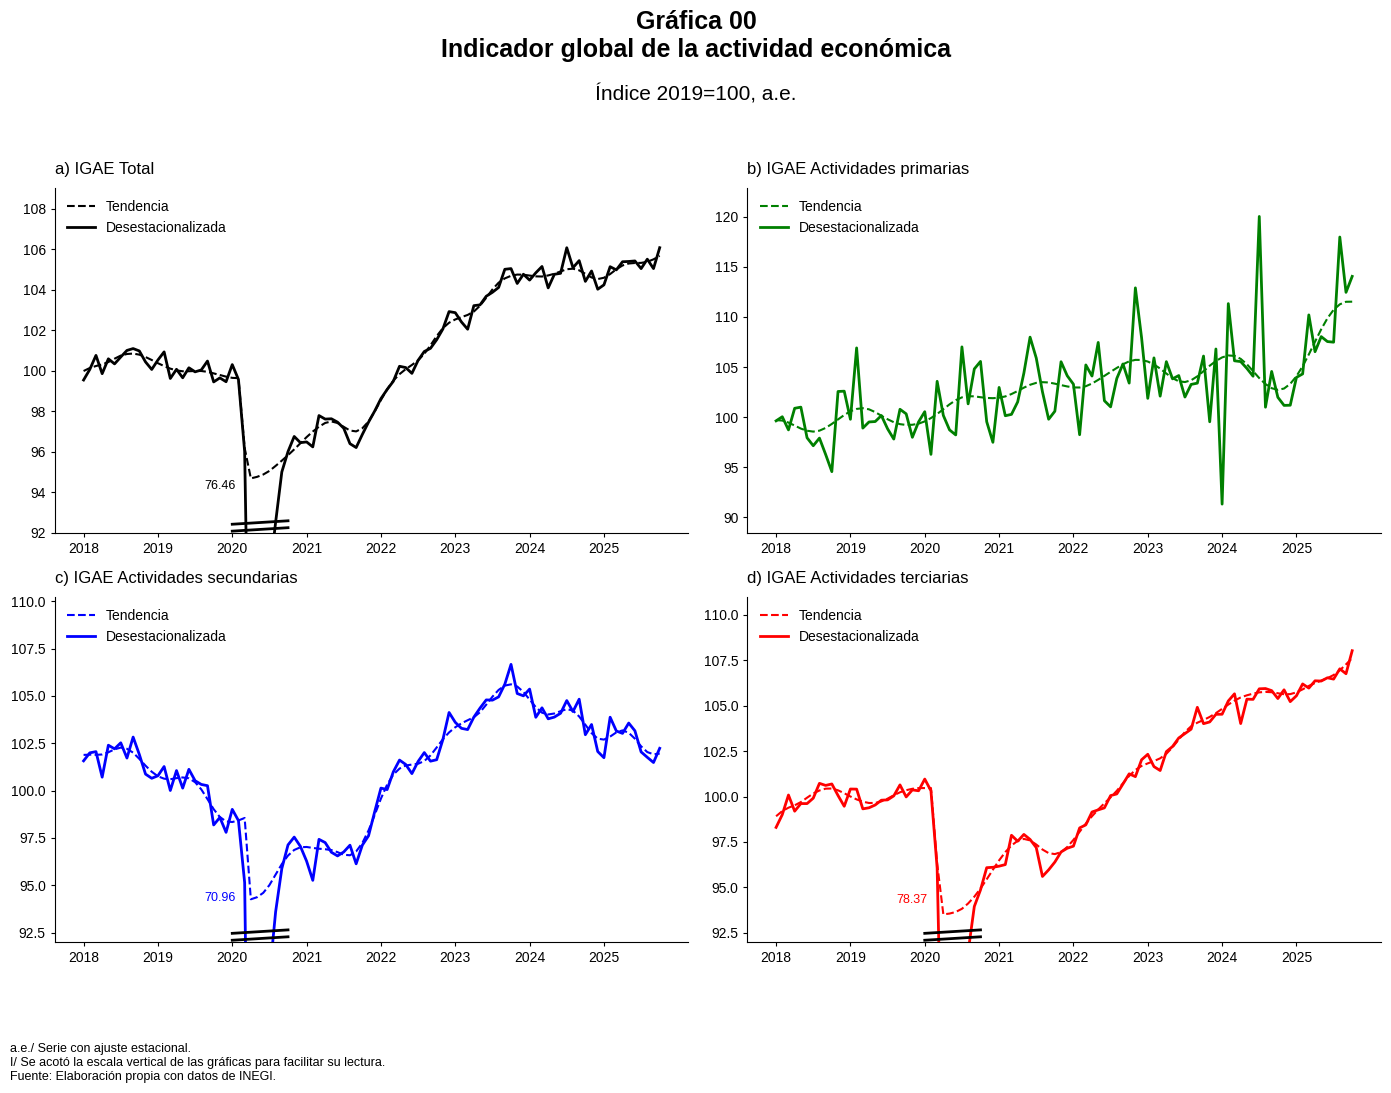

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Tipografía
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'Liberation Sans']
plt.rcParams['axes.unicode_minus'] = False

# Ensure the index is PeriodIndex('Q') for consistent x-axis handling
df_plot = base_filtrada.copy().sort_index()
df_plot.index = df_plot.index.to_period('M') # Convert to monthly period for consistency with previous plotting logic

# Define the series to plot and their colors
series_to_plot = {
    'IGAE Total': {'desest': 'IGAE Total Desest (2019=100)', 'tenden': 'IGAE Total Tenden (2019=100)', 'color': 'black', 'title_prefix': 'a)'},
    'IGAE Actividades primarias': {'desest': 'IGAE Prim Desest (2019=100)', 'tenden': 'IGAE Prim Tenden (2019=100)', 'color': 'green', 'title_prefix': 'b)'},
    'IGAE Actividades secundarias': {'desest': 'IGAE Sec Desest (2019=100)', 'tenden': 'IGAE Sec Tenden (2019=100)', 'color': 'blue', 'title_prefix': 'c)'},
    'IGAE Actividades terciarias': {'desest': 'IGAE Ter Desest (2019=100)', 'tenden': 'IGAE Ter Tenden (2019=100)', 'color': 'red', 'title_prefix': 'd)'}
}

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=False) # Increased figure size
axes = axes.flatten() # Flatten the 2x2 array of axes for easy iteration

# Create numeric x-axis
x = np.arange(len(df_plot))

# X-axis labels (only years for monthly data)
year_labels = df_plot.index.strftime('%Y').unique()
jan_indices = [i for i, date in enumerate(df_plot.index) if date.month == 1]
start_year = df_plot.index.year.min()
end_year = df_plot.index.year.max()
jan_x_ticks = []
jan_x_labels = []
for i in jan_indices:
    if df_plot.index[i].year >= start_year and df_plot.index[i].year <= end_year:
        jan_x_ticks.append(x[i])
        jan_x_labels.append(str(df_plot.index[i].year))

# Calculate the starting x-coordinate for 2020 and the line length
x_start_2020 = jan_x_ticks[jan_x_labels.index('2020')] # x-coordinate for the beginning of 2020
line_length = x[int(len(x) / 10)] - x[0] # Original line length

# Calculate the x-coordinate for November 2019
x_nov_2019_idx = df_plot.index.get_loc(pd.Period('2019-11', freq='M'))
x_nov_2019 = x[x_nov_2019_idx]

for i, (sector, data) in enumerate(series_to_plot.items()):
    ax = axes[i]
    color = data['color']
    title_prefix = data['title_prefix']

    # Plot Tendencia (dashed line)
    ax.plot(
        x,
        df_plot[data['tenden']],
        color=color,
        label='Tendencia',
        linestyle='--'
    )

    # Plot Desestacionalizada (solid line)
    ax.plot(
        x,
        df_plot[data['desest']],
        color=color,
        linewidth=2,
        label='Desestacionalizada'
    )

    # Linea horizontal en cero
    ax.axhline(0, color='lightgray', linewidth=0.8)

    # X-axis labels
    ax.set_xticks(jan_x_ticks)
    ax.set_xticklabels(jan_x_labels)

    # Y-axis limits (dynamic for each subplot)
    min_val_desest = df_plot[data['desest']].min()
    max_val_desest = df_plot[data['desest']].max()
    min_val_tenden = df_plot[data['tenden']].min()
    max_val_tenden = df_plot[data['tenden']].max()

    min_overall = min(min_val_desest, min_val_tenden)
    max_overall = max(max_val_desest, max_val_tenden)

    padding_y = (max_overall - min_overall) * 0.1

    # Set y-axis start for panels 'a', 'c', and 'd'
    if sector in ['IGAE Total', 'IGAE Actividades secundarias', 'IGAE Actividades terciarias']:
        ax.set_ylim(92, max_overall + padding_y)

        # Add a slightly inclined line for panels 'a', 'c', 'd'
        ymin, ymax_current = ax.get_ylim()
        line_y_start = ymin + (ymax_current - ymin) * 0.025
        line_y_end = ymin + (ymax_current - ymin) * 0.035 # Slight inclination
        ax.plot([x_start_2020, x_start_2020 + line_length], [line_y_start, line_y_end], color='black', linewidth=2)
        # Second parallel line
        line_y_start_2 = ymin + (ymax_current - ymin) * 0.005 # Slightly lower than the first line
        line_y_end_2 = ymin + (ymax_current - ymin) * 0.015 # Slightly lower than the first line_y_end
        ax.plot([x_start_2020, x_start_2020 + line_length], [line_y_start_2, line_y_end_2], color='black', linewidth=2)

        # Add labels for minimum value of deseasonalized series
        desest_col = data['desest']
        min_val_desest = df_plot[desest_col].min()
        min_date_desest = df_plot[desest_col].idxmin() # This returns a Period('YYYY-MM', freq='M')
        min_x_coord_desest = x[df_plot.index.get_loc(min_date_desest)] # Get x-coord of actual minimum
        min_y_coord_desest = min_val_desest

        # Position the text slightly above ymin
        text_y_position = ymin + 2 # Increased offset for better visibility

        ax.annotate(f'{min_val_desest:.2f}',
                    xy=(min_x_coord_desest, 92), # Actual data point
                    xytext=(x_nov_2019, text_y_position),        # Text position (Nov 2019, bottom)
                    arrowprops=dict(facecolor=color, shrink=0.05, width=0, headwidth=0, headlength=0),
                    fontsize=9, color=color, ha='center', va='bottom')
    else:
        ax.set_ylim(min_overall - padding_y, max_overall + padding_y)

    # Titles and format
    ax.set_title(f'{title_prefix} {sector}', loc='left', pad=10)
    ax.legend(frameon=False, loc='upper left') # Legend for each subplot

    # Clean style
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(axis='x', length=3, labelbottom=True) # Ensure x-axis tick marks and labels are visible
    ax.tick_params(axis='y', length=3) # Ensure y-axis tick marks are visible
    ax.grid(axis='y', linestyle='', alpha=0.7)

# Adjust layout and add overall title and footnote
fig.suptitle('Gráfica 00\nIndicador global de la actividad económica', ha='center', y=1.02, fontsize=18, fontweight='bold') # Use 'color' and 'fontweight'
#Subtítulo
plt.figtext(
    0.5, 0.93, # Adjust position to be below suptitle and centered
    'Índice 2019=100, a.e.',
    ha='center', # Center horizontally
    fontsize=15
)
# Footnote
plt.figtext(
    0.01, -0.05, # Adjust position to avoid overlap with subtitle or main title
    'a.e./ Serie con ajuste estacional.\n' # Added line break
    'I/ Se acotó la escala vertical de las gráficas para facilitar su lectura.\n'
    'Fuente: Elaboración propia con datos de INEGI.',
    ha='left',
    fontsize=9
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjusted rect to have 4 values
plt.show()

# Gráfica 4: IGAE Secundarias

Llamar a la API

In [1]:
import requests
import json
import pandas as pd
from functools import reduce

# Configuración
token = '337db32f-2268-33f9-43e8-c853b84b6ee9'
# Define series_ids as a dictionary to correctly map IDs to names
series_ids = {
    '737261': "Manufacturas Desest",
    '737264': "Manufacturas Tenden",
    '737240': "Minería Desest",
    '737243': "Minería Tenden",
    '737254': "Construcción Desest",
    '737257': "Construcción Tenden",
    '737247': "Electricidad, agua y gas Desest",
    '737250': "Electricidad, agua y gas Tenden"

}

# Modify obtener_serie to accept and use the series_name for column renaming
def obtener_serie(serieID, token, serie_name):
    url = f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/{serieID}/es/00/false/BIE-BISE/2.0/{token}?type=json'
    response = requests.get(url)

    if response.status_code == 200:
        content = json.loads(response.content)
        observations = content['Series'][0]['OBSERVATIONS']

        # Crear DataFrame temporal
        df = pd.DataFrame(observations)

        # Mantener solo fecha y valor, renombrando el valor con el nombre descriptivo
        df = df[['TIME_PERIOD', 'OBS_VALUE']].copy()
        df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')
        df.rename(columns={'OBS_VALUE': serie_name}, inplace=True) # Use descriptive name here

        return df
    else:
        print(f"Error al consultar la serie {serieID} ({serie_name}), código {response.status_code}")
        return None

# 1. Obtener todas las series en una lista
# Iterate over dictionary items to get both ID and name
lista_dataframes = [obtener_serie(id, token, name) for id, name in series_ids.items()]

# 2. Eliminar posibles errores (Nones) de la lista
lista_dataframes = [df for df in lista_dataframes if df is not None]

# 3. Unir todos los DataFrames por la columna 'TIME_PERIOD'
# Asegúrate de que lista_dataframes no esté vacío para evitar un error con reduce
if lista_dataframes:
    df_final = reduce(lambda left, right: pd.merge(left, right, on='TIME_PERIOD', how='outer'), lista_dataframes)
else:
    df_final = pd.DataFrame() # O maneja el caso de no datos de otra manera

# Ordenar por fecha para que tenga sentido cronológico
df_final = df_final.sort_values('TIME_PERIOD').reset_index(drop=True)

# Establecer TIME_PERIOD como index
df_final = df_final.set_index('TIME_PERIOD')

print(df_final)

             Manufacturas Desest  Manufacturas Tenden  Minería Desest  \
TIME_PERIOD                                                             
1993/01                56.770736            58.258806      103.826429   
1993/02                59.073122            58.547385      104.847827   
1993/03                59.777948            58.826880      106.027348   
1993/04                59.204189            59.040520      106.687071   
1993/05                58.828165            59.198934      106.179136   
...                          ...                  ...             ...   
2025/07               105.390256           106.049648       87.708050   
2025/08               105.466932           105.759046       88.001882   
2025/09               105.708304           105.670890       88.658186   
2025/10               105.479044           105.744862       89.296367   
2025/11               105.989954           105.938435       89.285633   

             Minería Tenden  Construcción Desest  

Filtrar datos

In [2]:
df_rebased = df_final.copy()

# Convert TIME_PERIOD index to datetime objects if it's not already
df_rebased.index = pd.to_datetime(df_rebased.index, format='%Y/%m')

# Filter for the year 2019 to get the base values
df_2019 = df_rebased[df_rebased.index.year == 2019]

# Calculate the average for 2019 for both series
base_value_desest1 = df_2019['Manufacturas Desest'].mean()
base_value_tenden1 = df_2019['Manufacturas Tenden'].mean()
base_value_desest2 = df_2019['Minería Desest'].mean()
base_value_tenden2 = df_2019['Minería Tenden'].mean()
base_value_desest3 = df_2019['Construcción Desest'].mean()
base_value_tenden3 = df_2019['Construcción Tenden'].mean()
base_value_desest4 = df_2019['Electricidad, agua y gas Desest'].mean()
base_value_tenden4 = df_2019['Electricidad, agua y gas Tenden'].mean()

# Rebase the series to 2019=100
df_rebased['Manufacturas Desest (2019=100)'] = (df_rebased['Manufacturas Desest'] / base_value_desest1) *100
df_rebased['Manufacturas Tenden (2019=100)'] = (df_rebased['Manufacturas Tenden'] / base_value_tenden1) *100
df_rebased['Minería Desest (2019=100)'] = (df_rebased['Minería Desest'] / base_value_desest2) *100
df_rebased['Minería Tenden (2019=100)'] = (df_rebased['Minería Tenden'] / base_value_tenden2) *100
df_rebased['Construcción Desest (2019=100)'] = (df_rebased['Construcción Desest'] / base_value_desest3) *100
df_rebased['Construcción Tenden (2019=100)'] = (df_rebased['Construcción Tenden'] / base_value_tenden3) *100
df_rebased['Electricidad, agua y gas Desest (2019=100)'] = (df_rebased['Electricidad, agua y gas Desest'] / base_value_desest4) *100
df_rebased['Electricidad, agua y gas Tenden (2019=100)'] = (df_rebased['Electricidad, agua y gas Tenden'] / base_value_tenden4) *100

# Display the head and tail of the new DataFrame with rebased columns
print("DataFrame con IGAE rebasado a 2019=100:")
display(df_rebased.head())
display(df_rebased.tail())

DataFrame con IGAE rebasado a 2019=100:


,Manufacturas Desest,Manufacturas Tenden,Minería Desest,Minería Tenden,Construcción Desest,Construcción Tenden,"Electricidad, agua y gas Desest","Electricidad, agua y gas Tenden",Manufacturas Desest (2019=100),Manufacturas Tenden (2019=100),Minería Desest (2019=100),Minería Tenden (2019=100),Construcción Desest (2019=100),Construcción Tenden (2019=100),"Electricidad, agua y gas Desest (2019=100)","Electricidad, agua y gas Tenden (2019=100)"
TIME_PERIOD,,,,,,,,,,,,,,,,
1993-01-01,56.770736,58.258806,103.826429,104.631209,68.086525,69.384602,32.320815,32.397862,56.782294,58.224051,109.626426,110.357088,70.792862,72.246408,34.140861,34.179297
1993-02-01,59.073122,58.547385,104.847827,105.131583,70.049339,69.587192,32.336994,32.350052,59.085148,58.512458,110.704881,110.884843,72.833695,72.457355,34.157950,34.128859
1993-03-01,59.777948,58.826880,106.027348,105.638498,70.195985,69.742317,32.150284,32.253843,59.790118,58.791786,111.950294,111.419500,72.986170,72.618878,33.960726,34.027359
1993-04-01,59.204189,59.040520,106.687071,106.109258,69.634600,69.799821,32.248782,32.122628,59.216242,59.005298,112.646870,111.916022,72.402470,72.678754,34.064772,33.888929
1993-05-01,58.828165,59.198934,106.179136,106.476315,70.683077,69.718582,32.138608,31.950471,58.840141,59.163618,112.110561,112.303165,73.492624,72.594164,33.948393,33.707305


,Manufacturas Desest,Manufacturas Tenden,Minería Desest,Minería Tenden,Construcción Desest,Construcción Tenden,"Electricidad, agua y gas Desest","Electricidad, agua y gas Tenden",Manufacturas Desest (2019=100),Manufacturas Tenden (2019=100),Minería Desest (2019=100),Minería Tenden (2019=100),Construcción Desest (2019=100),Construcción Tenden (2019=100),"Electricidad, agua y gas Desest (2019=100)","Electricidad, agua y gas Tenden (2019=100)"
TIME_PERIOD,,,,,,,,,,,,,,,,
2025-07-01,105.390256,106.049648,87.708050,87.251398,103.046958,102.179046,66.278110,66.596628,105.411711,105.986383,92.607635,92.026177,107.142920,106.393478,70.010355,70.258523
2025-08-01,105.466932,105.759046,88.001882,87.864121,101.055872,101.833825,67.021753,67.005795,105.488402,105.695954,92.917881,92.672431,105.072691,106.034018,70.795873,70.690188
2025-09-01,105.708304,105.670890,88.658186,88.435839,98.925594,101.947571,67.326042,67.509213,105.729823,105.607851,93.610848,93.275436,102.857738,106.152456,71.117297,71.221288
2025-10-01,105.479044,105.744862,89.296367,88.843194,102.993774,102.517110,68.397423,68.024406,105.500517,105.681778,94.284679,93.705082,107.087622,106.745486,72.249010,71.764809
2025-11-01,105.989954,105.938435,89.285633,89.095136,104.612238,103.439461,68.418823,68.493993,106.011531,105.875236,94.273346,93.970812,108.770418,107.705879,72.271615,72.260217


In [3]:
# Define la fecha de inicio para esta sección
fecha_inicio = '2018-01-01'

# Filtra el DataFrame df_rebased (de Gráfica 4) desde la fecha de inicio
base_filtrada = df_rebased[df_rebased.index >= fecha_inicio].copy()
display(base_filtrada.head())
display(base_filtrada.tail())

,Manufacturas Desest,Manufacturas Tenden,Minería Desest,Minería Tenden,Construcción Desest,Construcción Tenden,"Electricidad, agua y gas Desest","Electricidad, agua y gas Tenden",Manufacturas Desest (2019=100),Manufacturas Tenden (2019=100),Minería Desest (2019=100),Minería Tenden (2019=100),Construcción Desest (2019=100),Construcción Tenden (2019=100),"Electricidad, agua y gas Desest (2019=100)","Electricidad, agua y gas Tenden (2019=100)"
TIME_PERIOD,,,,,,,,,,,,,,,,
2018-01-01,98.513920,98.974316,104.923143,103.538481,101.111824,101.856040,100.353414,99.601399,98.533975,98.915271,110.784404,109.204560,105.130867,106.057150,106.004502,105.078101
2018-02-01,98.611113,99.045223,102.423728,103.318668,103.633611,101.634062,101.179256,100.051171,98.631188,98.986137,108.145366,108.972718,107.752891,105.826016,106.876849,105.552604
2018-03-01,100.169012,99.171059,102.260287,102.907586,101.345287,101.405124,98.130957,100.400421,100.189404,99.111898,107.972795,108.539140,105.373610,105.587635,103.656895,105.921058
2018-04-01,98.147890,99.424456,102.744288,102.319512,98.245069,101.127633,101.590344,100.672941,98.167870,99.365143,108.483834,107.918884,102.150163,105.298699,107.311087,106.208563
2018-05-01,100.265582,99.818889,102.750282,101.611185,101.807714,100.870640,97.272375,100.863758,100.285993,99.759341,108.490163,107.171794,105.854418,105.031106,102.749965,106.409872


,Manufacturas Desest,Manufacturas Tenden,Minería Desest,Minería Tenden,Construcción Desest,Construcción Tenden,"Electricidad, agua y gas Desest","Electricidad, agua y gas Tenden",Manufacturas Desest (2019=100),Manufacturas Tenden (2019=100),Minería Desest (2019=100),Minería Tenden (2019=100),Construcción Desest (2019=100),Construcción Tenden (2019=100),"Electricidad, agua y gas Desest (2019=100)","Electricidad, agua y gas Tenden (2019=100)"
TIME_PERIOD,,,,,,,,,,,,,,,,
2025-07-01,105.390256,106.049648,87.708050,87.251398,103.046958,102.179046,66.278110,66.596628,105.411711,105.986383,92.607635,92.026177,107.142920,106.393478,70.010355,70.258523
2025-08-01,105.466932,105.759046,88.001882,87.864121,101.055872,101.833825,67.021753,67.005795,105.488402,105.695954,92.917881,92.672431,105.072691,106.034018,70.795873,70.690188
2025-09-01,105.708304,105.670890,88.658186,88.435839,98.925594,101.947571,67.326042,67.509213,105.729823,105.607851,93.610848,93.275436,102.857738,106.152456,71.117297,71.221288
2025-10-01,105.479044,105.744862,89.296367,88.843194,102.993774,102.517110,68.397423,68.024406,105.500517,105.681778,94.284679,93.705082,107.087622,106.745486,72.249010,71.764809
2025-11-01,105.989954,105.938435,89.285633,89.095136,104.612238,103.439461,68.418823,68.493993,106.011531,105.875236,94.273346,93.970812,108.770418,107.705879,72.271615,72.260217


Graficar

# Gráfica 6: IGAE Terciarias

Llamar a la API

In [5]:
import requests
import json
import pandas as pd
from functools import reduce

# Configuración
token = '337db32f-2268-33f9-43e8-c853b84b6ee9'
# Define series_ids as a dictionary to correctly map IDs to names
series_ids = {
    '737268': "IGAE Servicios Desest",
    '737271': "IGAE Servicios Tenden",
    '737275': "Comercio al por mayor Desest",
    '737278': "Comercio al por mayor Tenden",
    '737289': "Transportes, correo y almacenamiento Desest",
    '737292': "Transportes, correo y almacenamiento Tenden",
    '737282': "Comercio al por menor, agua y gas Desest",
    '737285': "Comercio al por menor, agua y gas Tenden",
    '737310': "Inmobiliarios y de alquiler Desest",
    '737313': "Inmobiliarios y de alquiler Tenden",
    '737296': "Información en medios masivos Desest",
    '737299': "Información en medios masivos Tenden",
    '737303': "Financieros y de seguros Desest",
    '737306': "Financieros y de seguros Tenden",
    '737317': "Profesionales, científicos y técnicos Desest",
    '737320': "Profesionales, científicos y técnicos Tenden",
    '737345': "Esparcimiento, culturales y deportivos Desest",
    '737348': "Esparcimiento, culturales y deportivos Tenden",
    '737352': "Alojamiento temporal y preparación de alimentos Desest",
    '737355': "Alojamiento temporal y preparación de alimentos Tenden",
    '737324': "Apoyo a los negocios Desest",
    '737327': "Apoyo a los negocios Tenden",
    '737338': "Salud y asistencia social Desest",
    '737341': "Salud y asistencia social Tenden",
    '737331': "Educativos Desest",
    '737334': "Educativos Tenden",
    '737359': "Otros excepto gubernamentales Desest",
    '737362': "Otros excepto gubernamentales Tenden",
    '737366': "Actividades legislativas y gubernamentales Desest",
    '737369': "Actividades legislativas y gubernamentales Tenden"

}

# Modify obtener_serie to accept and use the series_name for column renaming
def obtener_serie(serieID, token, serie_name):
    url = f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/{serieID}/es/00/false/BIE-BISE/2.0/{token}?type=json'
    response = requests.get(url)

    if response.status_code == 200:
        content = json.loads(response.content)
        observations = content['Series'][0]['OBSERVATIONS']

        # Crear DataFrame temporal
        df = pd.DataFrame(observations)

        # Mantener solo fecha y valor, renombrando el valor con el nombre descriptivo
        df = df[['TIME_PERIOD', 'OBS_VALUE']].copy()
        df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')
        df.rename(columns={'OBS_VALUE': serie_name}, inplace=True) # Use descriptive name here

        return df
    else:
        print(f"Error al consultar la serie {serieID} ({serie_name}), código {response.status_code}")
        return None

# 1. Obtener todas las series en una lista
# Iterate over dictionary items to get both ID and name
lista_dataframes = [obtener_serie(id, token, name) for id, name in series_ids.items()]

# 2. Eliminar posibles errores (Nones) de la lista
lista_dataframes = [df for df in lista_dataframes if df is not None]

# 3. Unir todos los DataFrames por la columna 'TIME_PERIOD'
# Asegúrate de que lista_dataframes no esté vacío para evitar un error con reduce
if lista_dataframes:
    df_final = reduce(lambda left, right: pd.merge(left, right, on='TIME_PERIOD', how='outer'), lista_dataframes)
else:
    df_final = pd.DataFrame() # O maneja el caso de no datos de otra manera

# Ordenar por fecha para que tenga sentido cronológico
df_final = df_final.sort_values('TIME_PERIOD').reset_index(drop=True)

# Establecer TIME_PERIOD como index
df_final = df_final.set_index('TIME_PERIOD')

print(df_final)

             IGAE Servicios Desest  IGAE Servicios Tenden  \
TIME_PERIOD                                                 
1993/01                  52.302078              52.673257   
1993/02                  52.998473              52.815502   
1993/03                  53.108145              52.963284   
1993/04                  52.989580              53.104345   
1993/05                  53.301794              53.225351   
...                            ...                    ...   
2025/07                 106.703856             106.912003   
2025/08                 107.263530             107.124491   
2025/09                 106.956731             107.379971   
2025/10                 108.152404             107.645447   
2025/11                 107.749252             107.894020   

             Comercio al por mayor Desest  Comercio al por mayor Tenden  \
TIME_PERIOD                                                               
1993/01                         42.599790               

Convertir a año base 2019=100

In [6]:
df_rebased = df_final.copy()

# Convierte el índice TIME_PERIOD en objetos datetime si aún no lo es
df_rebased.index = pd.to_datetime(df_rebased.index, format='%Y/%m')

# Filtrar para obtener los valores base
df_2019 = df_rebased[df_rebased.index.year == 2019]

# Calcular el promedio para el año 2019 para ambas series
base_value_1 = df_2019['IGAE Servicios Desest'].mean()
base_value_2 = df_2019['IGAE Servicios Tenden'].mean()
base_value_3 = df_2019['Comercio al por mayor Desest'].mean()
base_value_4 = df_2019['Comercio al por mayor Tenden'].mean()
base_value_5 = df_2019['Transportes, correo y almacenamiento Desest'].mean()
base_value_6 = df_2019['Transportes, correo y almacenamiento Tenden'].mean()
base_value_7 = df_2019['Comercio al por menor, agua y gas Desest'].mean()
base_value_8 = df_2019['Comercio al por menor, agua y gas Tenden'].mean()
base_value_9 = df_2019['Inmobiliarios y de alquiler Desest'].mean()
base_value_10 = df_2019['Inmobiliarios y de alquiler Tenden'].mean()
base_value_11 = df_2019['Información en medios masivos Desest'].mean()
base_value_12 = df_2019['Información en medios masivos Tenden'].mean()
base_value_13 = df_2019['Financieros y de seguros Desest'].mean()
base_value_14 = df_2019['Financieros y de seguros Tenden'].mean()
base_value_15 = df_2019['Profesionales, científicos y técnicos Desest'].mean()
base_value_16 = df_2019['Profesionales, científicos y técnicos Tenden'].mean()
base_value_17 = df_2019['Esparcimiento, culturales y deportivos Desest'].mean()
base_value_18 = df_2019['Esparcimiento, culturales y deportivos Tenden'].mean()
base_value_19 = df_2019['Alojamiento temporal y preparación de alimentos Desest'].mean()
base_value_20 = df_2019['Alojamiento temporal y preparación de alimentos Tenden'].mean()
base_value_21 = df_2019['Apoyo a los negocios Desest'].mean()
base_value_22 = df_2019['Apoyo a los negocios Tenden'].mean()
base_value_23 = df_2019['Salud y asistencia social Desest'].mean()
base_value_24 = df_2019['Salud y asistencia social Tenden'].mean()
base_value_25 = df_2019['Educativos Desest'].mean()
base_value_26 = df_2019['Educativos Tenden'].mean()
base_value_27 = df_2019['Otros excepto gubernamentales Desest'].mean()
base_value_28 = df_2019['Otros excepto gubernamentales Tenden'].mean()
base_value_29 = df_2019['Actividades legislativas y gubernamentales Desest'].mean()
base_value_30 = df_2019['Actividades legislativas y gubernamentales Tenden'].mean()


# Cambiar el año base
df_rebased['IGAE Servicios Desest (2019=100)'] = (df_rebased['IGAE Servicios Desest'] / base_value_1) *100
df_rebased['IGAE Servicios Tenden (2019=100)'] = (df_rebased['IGAE Servicios Tenden'] / base_value_2) *100
df_rebased['Comercio al por mayor Desest (2019=100)'] = (df_rebased['Comercio al por mayor Desest'] / base_value_3) *100
df_rebased['Comercio al por mayor Tenden (2019=100)'] = (df_rebased['Comercio al por mayor Tenden'] / base_value_4) *100
df_rebased['Transportes, correo y almacenamiento Desest (2019=100)'] = (df_rebased['Transportes, correo y almacenamiento Desest'] / base_value_5) *100
df_rebased['Transportes, correo y almacenamiento Tenden (2019=100)'] = (df_rebased['Transportes, correo y almacenamiento Tenden'] / base_value_6) *100
df_rebased['Comercio al por menor, agua y gas Desest (2019=100)'] = (df_rebased['Comercio al por menor, agua y gas Desest'] / base_value_7) *100
df_rebased['Comercio al por menor, agua y gas Tenden (2019=100)'] = (df_rebased['Comercio al por menor, agua y gas Tenden'] / base_value_8) *100
df_rebased['Inmobiliarios y de alquiler Desest (2019=100)'] = (df_rebased['Inmobiliarios y de alquiler Desest'] / base_value_9) *100
df_rebased['Inmobiliarios y de alquiler Tenden (2019=100)'] = (df_rebased['Inmobiliarios y de alquiler Tenden'] / base_value_10) *100
df_rebased['Información en medios masivos Desest (2019=100)'] = (df_rebased['Información en medios masivos Desest'] / base_value_11) *100
df_rebased['Información en medios masivos Tenden (2019=100)'] = (df_rebased['Información en medios masivos Tenden'] / base_value_12) *100
df_rebased['Financieros y de seguros Desest (2019=100)'] = (df_rebased['Financieros y de seguros Desest'] / base_value_13) *100
df_rebased['Financieros y de seguros Tenden (2019=100)'] = (df_rebased['Financieros y de seguros Tenden'] / base_value_14) *100
df_rebased['Profesionales, científicos y técnicos Desest (2019=100)'] = (df_rebased['Profesionales, científicos y técnicos Desest'] / base_value_15) *100
df_rebased['Profesionales, científicos y técnicos Tenden (2019=100)'] = (df_rebased['Profesionales, científicos y técnicos Tenden'] / base_value_16) *100
df_rebased['Esparcimiento, culturales y deportivos Desest (2019=100)'] = (df_rebased['Esparcimiento, culturales y deportivos Desest'] / base_value_17) *100
df_rebased['Esparcimiento, culturales y deportivos Tenden (2019=100)'] = (df_rebased['Esparcimiento, culturales y deportivos Tenden'] / base_value_18) *100
df_rebased['Alojamiento temporal y preparación de alimentos Desest (2019=100)'] = (df_rebased['Alojamiento temporal y preparación de alimentos Desest'] / base_value_19) *100
df_rebased['Alojamiento temporal y preparación de alimentos Tenden (2019=100)'] = (df_rebased['Alojamiento temporal y preparación de alimentos Tenden'] / base_value_20) *100
df_rebased['Apoyo a los negocios Desest (2019=100)'] = (df_rebased['Apoyo a los negocios Desest'] / base_value_21) *100
df_rebased['Apoyo a los negocios Tenden (2019=100)'] = (df_rebased['Apoyo a los negocios Desest'] / base_value_22) *100
df_rebased['Salud y asistencia social Desest (2019=100)'] = (df_rebased['Salud y asistencia social Desest'] / base_value_23) *100
df_rebased['Salud y asistencia social Tenden (2019=100)'] = (df_rebased['Salud y asistencia social Desest'] / base_value_24) *100
df_rebased['Educativos Desest (2019=100)'] = (df_rebased['Educativos Desest'] / base_value_25) *100
df_rebased['Educativos Tenden (2019=100)'] = (df_rebased['Educativos Tenden'] / base_value_26) *100
df_rebased['Otros excepto gubernamentales Desest (2019=100)'] = (df_rebased['Otros excepto gubernamentales Desest'] / base_value_27) *100
df_rebased['Otros excepto gubernamentales Tenden (2019=100)'] = (df_rebased['Otros excepto gubernamentales Desest'] / base_value_28) *100
df_rebased['Actividades legislativas y gubernamentales Desest (2019=100)'] = (df_rebased['Actividades legislativas y gubernamentales Desest'] / base_value_29) *100
df_rebased['Actividades legislativas y gubernamentales Tenden (2019=100)'] = (df_rebased['Actividades legislativas y gubernamentales Desest'] / base_value_30) *100


# Mostrar la cabecera y la cola del nuevo DataFrame con columnas rebasadas
print("DataFrame con año base 2019=100:")
display(df_rebased.head())
display(df_rebased.tail())

DataFrame con año base 2019=100:


,IGAE Servicios Desest,IGAE Servicios Tenden,Comercio al por mayor Desest,Comercio al por mayor Tenden,"Transportes, correo y almacenamiento Desest","Transportes, correo y almacenamiento Tenden","Comercio al por menor, agua y gas Desest","Comercio al por menor, agua y gas Tenden",Inmobiliarios y de alquiler Desest,Inmobiliarios y de alquiler Tenden,...,Apoyo a los negocios Desest (2019=100),Apoyo a los negocios Tenden (2019=100),Salud y asistencia social Desest (2019=100),Salud y asistencia social Tenden (2019=100),Educativos Desest (2019=100),Educativos Tenden (2019=100),Otros excepto gubernamentales Desest (2019=100),Otros excepto gubernamentales Tenden (2019=100),Actividades legislativas y gubernamentales Desest (2019=100),Actividades legislativas y gubernamentales Tenden (2019=100)
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
1993-01-01,52.302078,52.673257,42.599790,42.831867,46.931459,47.180460,51.674882,52.105412,49.986812,50.013362,...,42.548905,42.307700,55.771263,55.861180,70.862404,71.756505,63.694491,63.814274,82.773727,82.948250
1993-02-01,52.998473,52.815502,43.216985,42.925510,47.406441,47.195408,52.407594,52.120792,50.213282,50.185368,...,57.549465,57.223224,55.850195,55.940239,72.147045,72.091143,64.551575,64.672970,82.468955,82.642834
1993-03-01,53.108145,52.963284,42.811980,42.998426,47.425720,47.196643,52.346952,52.057534,50.162704,50.366326,...,50.357679,50.072207,55.573097,55.662695,74.075416,72.414835,65.536264,65.659511,82.503687,82.677640
1993-04-01,52.989580,53.104345,43.034333,43.066120,46.948946,47.190026,51.885796,51.958901,50.523861,50.555244,...,52.422081,52.124906,57.876467,57.969778,72.906474,72.726255,64.220401,64.341173,82.448440,82.622276
1993-05-01,53.301794,53.225351,43.220009,43.120776,47.250777,47.180146,51.670964,51.828541,50.764165,50.748909,...,52.653363,52.354877,57.750396,57.843504,72.936318,72.985441,64.401262,64.522374,82.451920,82.625764


,IGAE Servicios Desest,IGAE Servicios Tenden,Comercio al por mayor Desest,Comercio al por mayor Tenden,"Transportes, correo y almacenamiento Desest","Transportes, correo y almacenamiento Tenden","Comercio al por menor, agua y gas Desest","Comercio al por menor, agua y gas Tenden",Inmobiliarios y de alquiler Desest,Inmobiliarios y de alquiler Tenden,...,Apoyo a los negocios Desest (2019=100),Apoyo a los negocios Tenden (2019=100),Salud y asistencia social Desest (2019=100),Salud y asistencia social Tenden (2019=100),Educativos Desest (2019=100),Educativos Tenden (2019=100),Otros excepto gubernamentales Desest (2019=100),Otros excepto gubernamentales Tenden (2019=100),Actividades legislativas y gubernamentales Desest (2019=100),Actividades legislativas y gubernamentales Tenden (2019=100)
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2025-07-01,106.703856,106.912003,102.014226,102.613942,114.843680,115.184746,118.300666,118.730498,114.392357,114.436871,...,27.778811,27.621336,111.670556,111.850597,101.482091,101.284026,97.414466,97.597663,101.618791,101.833046
2025-08-01,107.263530,107.124491,103.443150,103.068768,114.989297,115.157168,120.528002,119.080505,114.581829,114.567205,...,27.327202,27.172287,111.241637,111.420986,100.924428,101.283902,97.182646,97.365407,100.561053,100.773078
2025-09-01,106.956731,107.379971,103.216241,103.635168,115.194147,115.156531,117.729685,119.555000,114.731590,114.769567,...,27.191586,27.037440,112.082542,112.263247,101.144216,101.315705,97.199767,97.382560,101.667878,101.882237
2025-10-01,108.152404,107.645447,106.018706,104.041679,116.138852,115.211279,119.988205,120.084841,115.016695,115.020248,...,27.284876,27.130201,112.260884,112.441877,101.618672,101.403835,97.455232,97.638505,102.241247,102.456816
2025-11-01,107.749252,107.894020,103.674988,104.157449,114.474350,115.292250,121.770671,120.631966,115.352664,115.289204,...,27.660400,27.503597,112.599417,112.780955,101.431343,101.529762,99.167896,99.354389,101.194487,101.407848


<Figure size 1200x1200 with 0 Axes>

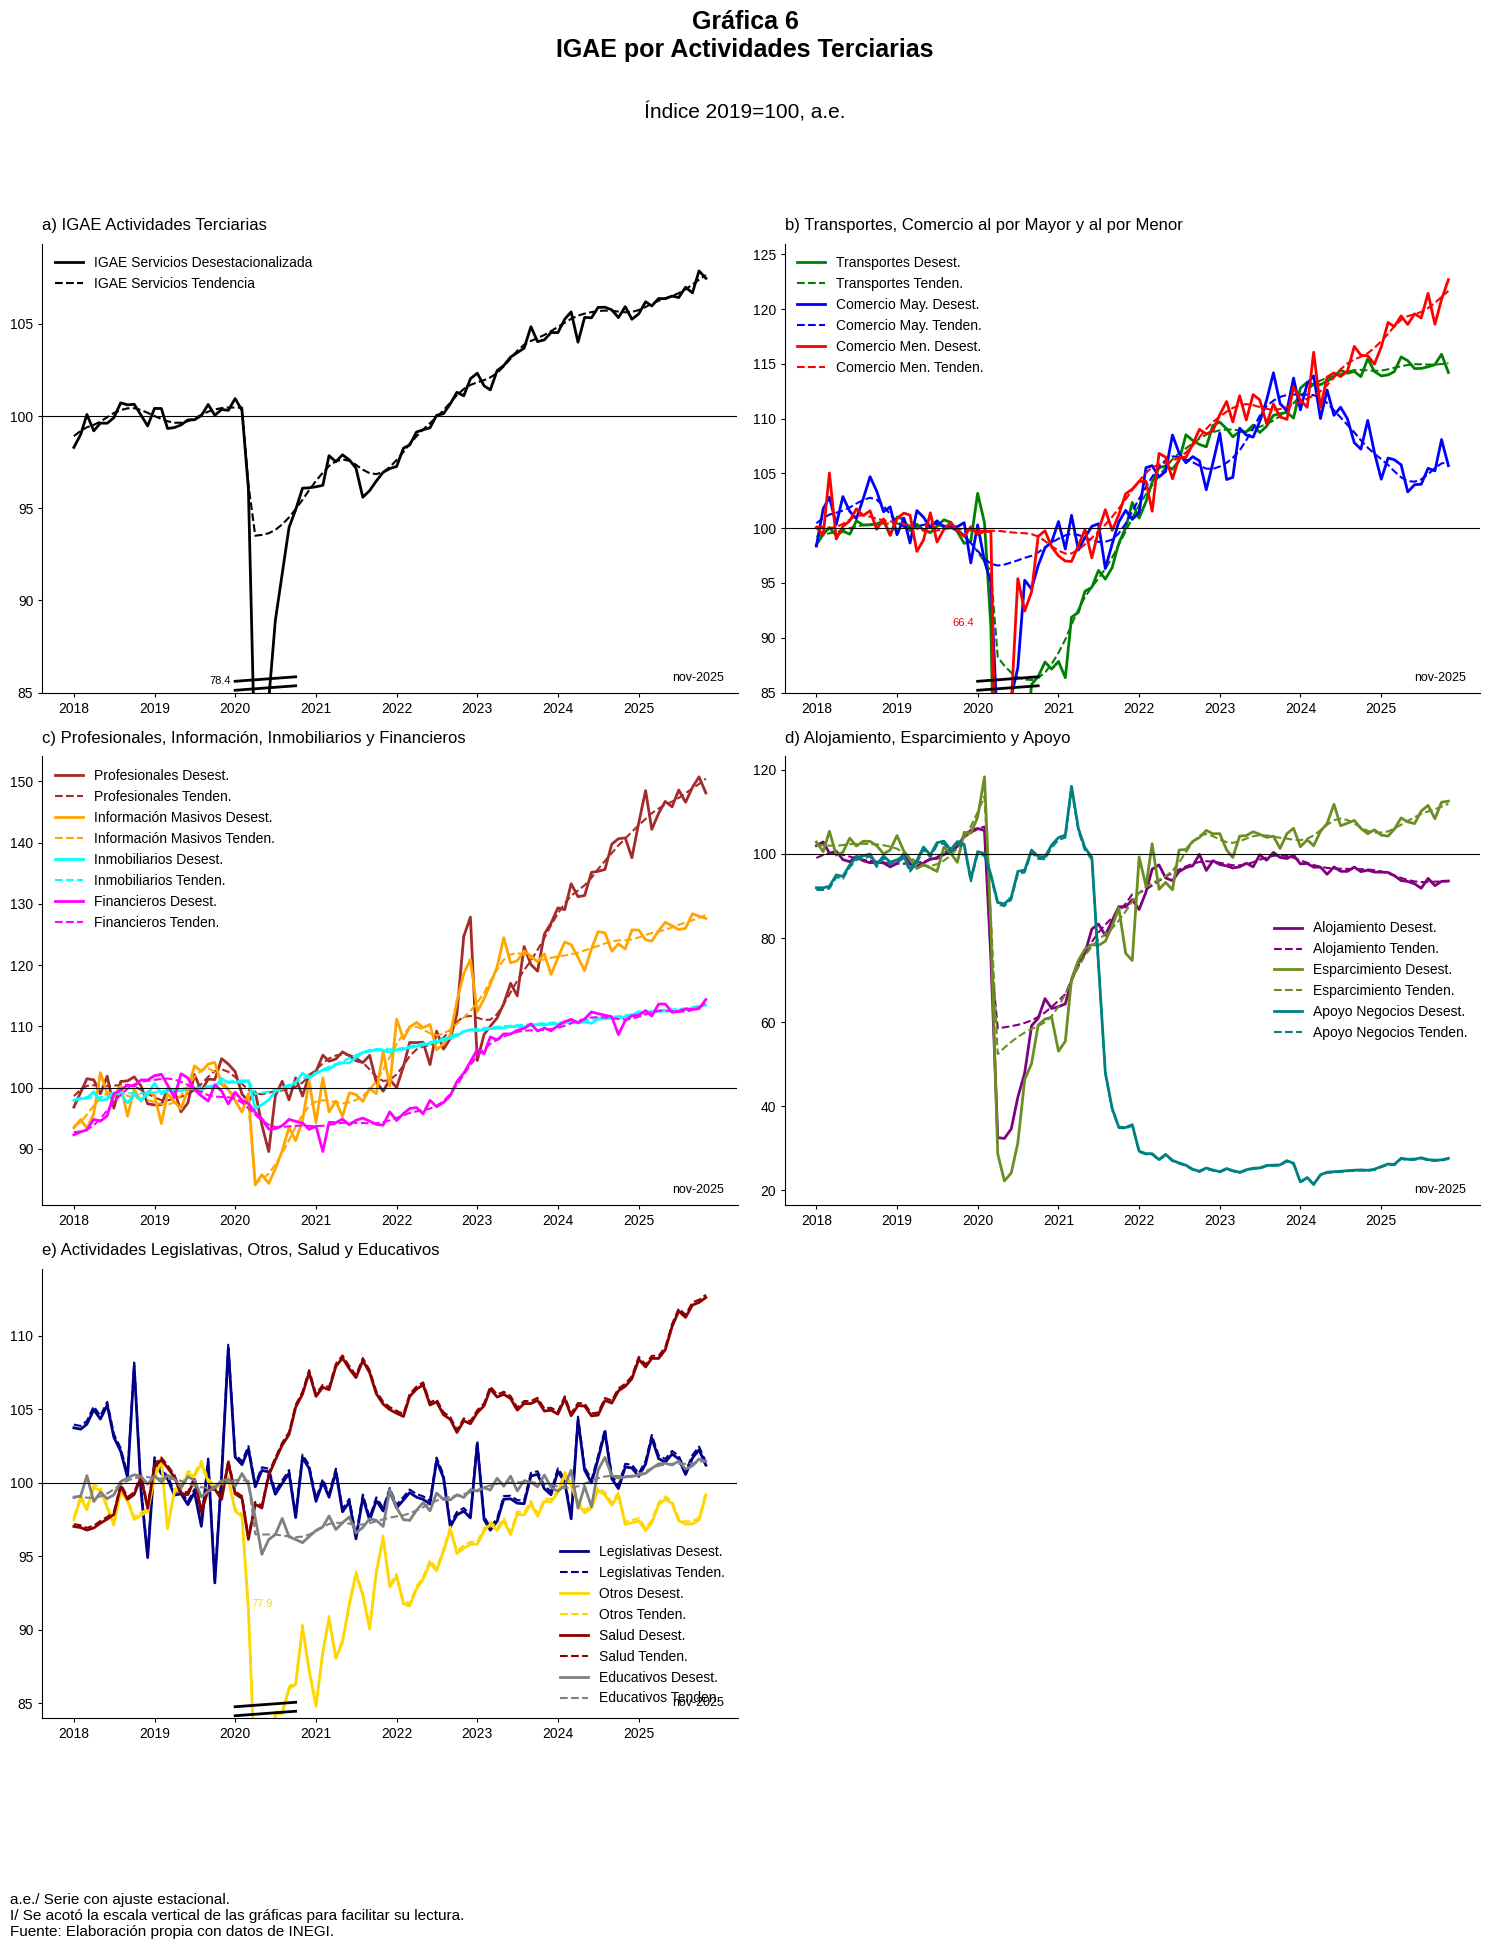

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

# =================================================
# TIPOGRAFÍA
# =================================================
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'Liberation Sans']
plt.rcParams['axes.unicode_minus'] = False

# =================================================
# PREPARAR DATAFRAME
# =================================================
df_plot = base_filtrada.copy().sort_index()
x = df_plot.index

# =================================================
# DISPOSICIÓN DEL GRÁFICO
# =================================================

fig = plt.figure(figsize=(12, 12))

# =================================================
# EJE X (ETIQUETAS ANUALES)
# =================================================
jan_x_ticks = [date for date in x if date.month == 1]
jan_x_labels = [str(date.year) for date in x if date.month == 1]

# =================================================
# DEFINICIÓN DE PANELES
# =================================================
panels = [
    # Panel 1: IGAE de actividades terciarias (Overall Services)
    {
        "name": "IGAE Actividades Terciarias",
        "title_prefix": "a)",
        "ylim": (85, None),
        "series": [
            {"col": "IGAE Servicios Desest (2019=100)", "label": "IGAE Servicios Desestacionalizada", "kind": "line", "style": {"color": "black", "linewidth": 2}},
            {"col": "IGAE Servicios Tenden (2019=100)", "label": "IGAE Servicios Tendencia", "kind": "line", "style": {"color": "black", "linestyle": "--"}}
        ],
        "brackets": [
            {"x_start": "2020-01", "length_frac": 0.10, "y_fracs": [(0.025, 0.035), (0.005, 0.015)]}
        ],
        "annotations": {
            "min": {"series_idx": 0, "dx": -30, "dy": 100}
        }
    },
    # Panel 2: Transportes, Comercio al por mayor y al por menor
    {
        "name": "Transportes, Comercio al por Mayor y al por Menor",
        "title_prefix": "b)",
        "ylim": (85, None),
        "series": [
            {"col": "Transportes, correo y almacenamiento Desest (2019=100)", "label": "Transportes Desest.", "kind": "line", "style": {"color": "green", "linewidth": 2}},
            {"col": "Transportes, correo y almacenamiento Tenden (2019=100)", "label": "Transportes Tenden.", "kind": "line", "style": {"color": "green", "linestyle": "--"}},
            {"col": "Comercio al por mayor Desest (2019=100)", "label": "Comercio May. Desest.", "kind": "line", "style": {"color": "blue", "linewidth": 2}},
            {"col": "Comercio al por mayor Tenden (2019=100)", "label": "Comercio May. Tenden.", "kind": "line", "style": {"color": "blue", "linestyle": "--"}},
            {"col": "Comercio al por menor, agua y gas Desest (2019=100)", "label": "Comercio Men. Desest.", "kind": "line", "style": {"color": "red", "linewidth": 2}},
            {"col": "Comercio al por menor, agua y gas Tenden (2019=100)", "label": "Comercio Men. Tenden.", "kind": "line", "style": {"color": "red", "linestyle": "--"}}
        ],
        "brackets": [
            {"x_start": "2020-01", "length_frac": 0.10, "y_fracs": [(0.025, 0.035), (0.005, 0.015)]}
        ],
        "annotations": {
            "min": {"series_idx": 4, "dx": -25, "dy": 200}
        }
    },
    # Panel 3: Profesionales, Información, Inmobiliarios y financieros
    {
        "name": "Profesionales, Información, Inmobiliarios y Financieros",
        "title_prefix": "c)",
        "ylim": (None, None),
        "series": [
            {"col": "Profesionales, científicos y técnicos Desest (2019=100)", "label": "Profesionales Desest.", "kind": "line", "style": {"color": "brown", "linewidth": 2}},
            {"col": "Profesionales, científicos y técnicos Tenden (2019=100)", "label": "Profesionales Tenden.", "kind": "line", "style": {"color": "brown", "linestyle": "--"}},
            {"col": "Información en medios masivos Desest (2019=100)", "label": "Información Masivos Desest.", "kind": "line", "style": {"color": "orange", "linewidth": 2}},
            {"col": "Información en medios masivos Tenden (2019=100)", "label": "Información Masivos Tenden.", "kind": "line", "style": {"color": "orange", "linestyle": "--"}},
            {"col": "Inmobiliarios y de alquiler Desest (2019=100)", "label": "Inmobiliarios Desest.", "kind": "line", "style": {"color": "cyan", "linewidth": 2}},
            {"col": "Inmobiliarios y de alquiler Tenden (2019=100)", "label": "Inmobiliarios Tenden.", "kind": "line", "style": {"color": "cyan", "linestyle": "--"}},
            {"col": "Financieros y de seguros Desest (2019=100)", "label": "Financieros Desest.", "kind": "line", "style": {"color": "magenta", "linewidth": 2}},
            {"col": "Financieros y de seguros Tenden (2019=100)", "label": "Financieros Tenden.", "kind": "line", "style": {"color": "magenta", "linestyle": "--"}}
        ]
    },
    # Panel 4: Alojamiento, Esparcimiento y Apoyo
    {
        "name": "Alojamiento, Esparcimiento y Apoyo",
        "title_prefix": "d)",
        "ylim": (None, None),
        "series": [
            {"col": "Alojamiento temporal y preparación de alimentos Desest (2019=100)", "label": "Alojamiento Desest.", "kind": "line", "style": {"color": "purple", "linewidth": 2}},
            {"col": "Alojamiento temporal y preparación de alimentos Tenden (2019=100)", "label": "Alojamiento Tenden.", "kind": "line", "style": {"color": "purple", "linestyle": "--"}},
            {"col": "Esparcimiento, culturales y deportivos Desest (2019=100)", "label": "Esparcimiento Desest.", "kind": "line", "style": {"color": "olivedrab", "linewidth": 2}},
            {"col": "Esparcimiento, culturales y deportivos Tenden (2019=100)", "label": "Esparcimiento Tenden.", "kind": "line", "style": {"color": "olivedrab", "linestyle": "--"}},
            {"col": "Apoyo a los negocios Desest (2019=100)", "label": "Apoyo Negocios Desest.", "kind": "line", "style": {"color": "teal", "linewidth": 2}},
            {"col": "Apoyo a los negocios Tenden (2019=100)", "label": "Apoyo Negocios Tenden.", "kind": "line", "style": {"color": "teal", "linestyle": "--"}}
        ]
    },
    # Panel 5: Actividades legislativas, Otros, Salud y Educativos
    {
        "name": "Actividades Legislativas, Otros, Salud y Educativos",
        "title_prefix": "e)",
        "ylim": (84, None),
        "series": [
            {"col": "Actividades legislativas y gubernamentales Desest (2019=100)", "label": "Legislativas Desest.", "kind": "line", "style": {"color": "darkblue", "linewidth": 2}},
            {"col": "Actividades legislativas y gubernamentales Tenden (2019=100)", "label": "Legislativas Tenden.", "kind": "line", "style": {"color": "darkblue", "linestyle": "--"}},
            {"col": "Otros excepto gubernamentales Desest (2019=100)", "label": "Otros Desest.", "kind": "line", "style": {"color": "gold", "linewidth": 2}},
            {"col": "Otros excepto gubernamentales Tenden (2019=100)", "label": "Otros Tenden.", "kind": "line", "style": {"color": "gold", "linestyle": "--"}},
            {"col": "Salud y asistencia social Desest (2019=100)", "label": "Salud Desest.", "kind": "line", "style": {"color": "darkred", "linewidth": 2}},
            {"col": "Salud y asistencia social Tenden (2019=100)", "label": "Salud Tenden.", "kind": "line", "style": {"color": "darkred", "linestyle": "--"}},
            {"col": "Educativos Desest (2019=100)", "label": "Educativos Desest.", "kind": "line", "style": {"color": "grey", "linewidth": 2}},
            {"col": "Educativos Tenden (2019=100)", "label": "Educativos Tenden.", "kind": "line", "style": {"color": "grey", "linestyle": "--"}}
        ],
        "brackets": [
            {"x_start": "2020-01", "length_frac": 0.10, "y_fracs": [(0.025, 0.035), (0.005, 0.015)]}
        ],
        "annotations": {
            "min": {"series_idx": 2, "dx": 0, "dy": 150}
        }
    }
]

# =================================================
# GENERAR GRÁFICOS
# =================================================

#Grafica las series
def plot_series(ax, x, df, series_def, ax2=None):
    lines = []
    labels = []
    for s in series_def:
        current_ax = ax2 if s.get("axis") == "secondary" and ax2 is not None else ax
        if s["col"] in df.columns:
            if s["kind"] == "line":
                line, = current_ax.plot(x, df[s["col"]], **s["style"])
            elif s["kind"] == "bar":
                line = current_ax.bar(x, df[s["col"]], **s["style"])
            lines.append(line)
            labels.append(s["label"])
        else:
            print(f"Warning: Column '{s['col']}' not found in DataFrame. Skipping.")
    return lines, labels

#Grafica las marcas de acotación
def draw_brackets(ax, x, idx, br):
    ymin, ymax = ax.get_ylim()
    x0 = idx.get_loc(pd.to_datetime(br["x_start"]))
    x_start = idx[x0]
    x_end = x_start + pd.DateOffset(months=int(len(x) * br["length_frac"]))
    for y0f, y1f in br["y_fracs"]:
        ax.plot([x_start, x_end],
                [ymin + (ymax-ymin)*y0f, ymin + (ymax-ymin)*y1f],
                color="black", lw=2)


#Grafica las etiquetas de datos
def annotate_extreme(ax, x, df, panel_config, annotation_cfg, extreme_type):
    series_idx_to_annotate = annotation_cfg["series_idx"]
    target_series = panel_config["series"][series_idx_to_annotate]
    col_name = target_series["col"]
    series_color = target_series["style"]["color"]

    if col_name not in df.columns:
        print(f"Warning: Column '{col_name}' for annotation not found in DataFrame. Skipping.")
        return

    if extreme_type == "min":
        extreme_value = df[col_name].min()
        extreme_date_index = df[col_name].idxmin()
        va_setting = 'top' # Align text top with the data point
    else: # extreme_type == "max"
        extreme_value = df[col_name].max()
        extreme_date_index = df[col_name].idxmax()
        va_setting = 'bottom' # Align text bottom with the data point

    x_val = extreme_date_index
    y_val = extreme_value

    ax.annotate(f'{extreme_value:.1f}',
                xy=(x_val, y_val),
                xytext=(annotation_cfg["dx"], annotation_cfg["dy"]),
                textcoords="offset points",
                ha='center', va=va_setting,
                fontsize=8, color=series_color,
                annotation_clip=False
    )

def draw_arrows(ax, arrows_config):
    for arrow in arrows_config:
        ax.annotate('',
                    xy=arrow["xy_frac"],
                    xytext=arrow["xytext_frac"],
                    xycoords='axes fraction', textcoords='axes fraction',
                    arrowprops=dict(arrowstyle=arrow.get("arrowstyle", "->"),
                                    color=arrow["color"],
                                    lw=arrow.get("linewidth", 1)))
def format_last_date(date):
    meses = {
        1: "ene", 2: "feb", 3: "mar", 4: "abr",
        5: "may", 6: "jun", 7: "jul", 8: "ago",
        9: "sep", 10: "oct", 11: "nov", 12: "dic"
    }
    return f"{meses[date.month]}-{date.year}"


num_paneles = len(panels)
nrows = 3 #<--------------------------------------------------------------------No. de filas
ncols = 2

fig, all_axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 18))

if ncols > 1 and nrows > 1:
    all_axes = all_axes.flatten()
elif nrows == 1 and ncols == 1:
    all_axes = [all_axes]
elif nrows == 1 or ncols == 1:
    all_axes = all_axes

fig.tight_layout(pad=3.0)

for i, panel in enumerate(panels):
    ax = all_axes[i]
    ax2 = None

    # Plot all series defined in panel["series"]
    lines = []
    labels = []
    for s_config in panel["series"]:
        if s_config["col"] in df_plot.columns:
            line, = ax.plot(x, df_plot[s_config["col"]], **s_config["style"])
            lines.append(line)
            labels.append(s_config["label"])
        else:
            print(f"Warning: Column '{s_config['col']}' not found for panel '{panel['name']}'. Skipping.")

    #Graficar línea horizontal
    ax.axhline(100, color="black", lw=0.8)
    ax.set_xticks(jan_x_ticks)
    ax.set_xticklabels(jan_x_labels, rotation=0, ha='center')

    if panel.get("ylim"):
        ymin, ymax = panel["ylim"]
        _, auto_max = ax.get_ylim()
        ax.set_ylim(ymin if ymin else ax.get_ylim()[0],
                    ymax if ymax else auto_max)

    # Establezca ylim para el eje secundario si existe y ylim se proporciona en el panel
    if ax2 and panel.get("ylim_secondary"):
        ymin_sec, ymax_sec = panel["ylim_secondary"]
        _, auto_max_sec = ax2.get_ylim()
        ax2.set_ylim(ymin_sec if ymin_sec else ax2.get_ylim()[0],
                     ymax_sec if ymax_sec else auto_max_sec)

    if "brackets" in panel:
        for br in panel["brackets"]:
            draw_brackets(ax, x, df_plot.index, br)

    if "annotations" in panel:
        if "min" in panel["annotations"]:
            annotate_extreme(ax, x, df_plot, panel, panel["annotations"]["min"], "min")
        if "max" in panel["annotations"]:
            annotate_extreme(ax, x, df_plot, panel, panel["annotations"]["max"], "max")

    if "arrows" in panel:
        draw_arrows(ax, panel["arrows"])

    ax.set_title(f"{panel['title_prefix']} {panel['name']}", loc='left', pad=10)

    # =================================================
    # FECHA ÚLTIMA OBSERVACIÓN
    # =================================================
    last_date = df_plot.index.max()
    last_date_label = format_last_date(last_date)

    ax.text(
        0.98, 0.02,
        last_date_label,
        transform=ax.transAxes,
        ha='right',
        va='bottom',
        fontsize=9,
        color='black'
    )

    ax.legend(lines, labels, frameon=False)
    ax.grid(False)

# =================================================
# TÍTULOS DEL PANELES
# =================================================

    ax.set_title(f"{panel['title_prefix']} {panel['name']}", loc='left', pad=10)

# =================================================
# ESTILO LIMPIO
# =================================================

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(axis='x', length=3, labelbottom=True)
    ax.grid(False)

    # Para el eje primario
    ax.spines['left'].set_visible(True)
    ax.tick_params(axis='y', labelleft=True, length=3)

    if ax2:
        # Para el eje primario
        ax.spines['right'].set_visible(False)

        # Para el eje secundario
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.tick_params(axis='y', labelright=False, length=3)
        ax2.grid(axis='y', linestyle=' ', alpha=0) # Changed to ':' for dotted grid lines
    else:
        ax.spines['right'].set_visible(False)


for j in range(i + 1, len(all_axes)):
    fig.delaxes(all_axes[j])

# =================================================
# TÍTULO DEL GRÁFICO
# =================================================

fig.suptitle('Gráfica 6\nIGAE por Actividades Terciarias', ha='center', y=1.02, fontsize=18, fontweight='bold')


# =================================================
# SUBTITULO DEL GRÁFICO
# =================================================

plt.figtext(
    0.5, 0.96,
    'Índice 2019=100, a.e.',
    ha='center',
    fontsize=15
)

# =================================================
# NOTA AL PIE
# =================================================

plt.figtext(
    0.01, -0.05,
    'a.e./ Serie con ajuste estacional.\n'
    'I/ Se acotó la escala vertical de las gráficas para facilitar su lectura.\n'
    'Fuente: Elaboración propia con datos de INEGI.',
    ha='left',
    fontsize=11
)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.show()